In [1]:
import torch
import sys
sys.path.append("/home/onyxia/work/Advanced-ML")
from data_loader import S3ParquetReader
from config import USER
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.optim import Adam
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import polars as pl

## Data Loading

Config initialisation

In [2]:
BUCKET = f"/{USER}/jane_street_data"
reader = S3ParquetReader(bucket=BUCKET)
FILE_KEY_S3 = "preprocessed.parquet/data_clean_symb_1.parquet"

In [3]:
data = reader.read_parquet(FILE_KEY_S3)
data.head()

date_id,time_id,symbol_id,weight,feature_05,feature_06,feature_07,feature_08,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_22,feature_23,feature_24,feature_25,feature_28,feature_29,feature_30,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_40,feature_41,feature_43,feature_44,feature_45,feature_46,…,feature_52,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8,feature_time_sin,feature_time_cos
i16,i16,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f64,f64
0,35,1,3.889038,0.127298,0.339121,-0.045494,0.151473,-0.038995,-0.644192,-0.193971,-0.016662,-0.213108,-0.045016,0.014899,0.128033,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.397016,0.694868,0.812098,-0.128621,0.025559,0.018694,-0.006306,-1.706433,-0.490941,0.425017,0.281025,-0.134582,0.046605,…,-0.207253,-0.307967,0.381731,0.756464,0.058235,0.060041,-0.479444,-0.000608,0.0,-0.000122,0.085259,-0.324355,-0.097414,-0.296044,0.21344,-0.20025,-0.11987,-0.007101,-0.693186,-0.181427,0.073886,-0.062266,0.136151,0.110356,0.055748,-0.028266,0.36224,-0.376568,-0.086291,-0.392552,-0.267725,-0.112329,-1.233082,0.131704,-0.024239,0.225461,0.974252
0,36,1,3.889038,0.114208,-1.419921,-0.505525,-0.258195,0.017889,-0.254385,0.015691,-0.020583,-0.15111,-0.034961,-0.045215,-0.411787,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.037745,-0.824408,-0.312367,0.272155,0.041673,0.051002,0.101001,-0.172871,0.356697,0.43781,-0.243426,0.116691,0.21925,…,0.174336,-0.325709,-0.301785,-0.332396,0.651199,-0.103911,-0.210683,0.088785,0.0,-0.013245,-0.067586,0.22172,0.347892,0.511532,-0.214167,-0.045423,-0.048534,0.048807,-0.407794,0.008081,-0.071584,0.056597,0.01653,-0.049644,-0.023103,-0.0531,0.283566,-0.397785,0.041572,0.001317,-0.112683,0.419467,-0.578848,0.269364,0.459819,0.231787,0.972767
0,37,1,3.889038,0.118826,-1.293755,-0.809856,0.268584,-0.056675,-0.273341,-0.016404,0.010669,0.172457,0.011381,0.013246,-0.016248,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.571682,0.168574,-0.042331,-0.55658,0.175519,-0.052067,0.053939,0.109843,-0.055707,-0.214608,-0.026042,-0.180718,-0.171372,…,-1.097941,-0.294437,-0.104787,0.504722,-0.285762,0.140226,-0.521822,-0.46183,0.0,0.226184,-0.100162,-0.029472,0.037072,0.097566,0.061552,-0.136708,-0.029742,-0.047774,-0.150518,-0.287006,-0.000054,-0.048201,-0.093462,-0.015866,0.051347,0.055587,0.260547,-0.299865,0.239627,-0.019651,-0.194262,0.321798,-0.683034,0.027111,0.075722,0.238102,0.97124
0,38,1,3.889038,-0.216346,-0.021069,-0.425764,-0.005701,-0.010654,0.302838,0.000491,-0.017648,-0.036415,-0.008958,0.384812,0.49453,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.202302,0.395804,-0.512155,0.642004,0.414221,0.113961,-0.131998,-0.374575,0.206433,-0.445924,-0.518108,0.268771,0.069906,…,0.08609,-0.610097,0.137679,-0.198983,-0.754921,-0.294851,0.352242,0.049567,0.0,-0.023089,0.036929,-0.176699,-0.503255,-0.449954,-0.134894,0.050516,-0.089379,0.004014,-0.204778,-0.144482,-0.082102,-0.050271,0.020269,-0.008658,0.096835,-0.042524,0.423799,-0.195033,0.145029,-0.076218,-0.304814,0.098249,-0.606483,-0.01076,-0.134628,0.244408,0.969673
0,39,1,3.889038,-0.660073,2.168059,0.903407,-0.101644,0.133174,-0.212203,-0.217244,0.006182,-0.076704,-0.027879,0.249095,-0.431726,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.511043,-0.221639,-0.014473,-0.572408,-0.297749,-0.126506,-0.083542,0.180433,-0.245343,0.052368,0.051568,-0.067317,0.585641,…,0.422847,1.033209,-0.497286,-0.080836,0.111428,0.3511

# Split and standardization

In [4]:
target = "responder_6"
features = [col for col in data.columns if "feature" in col]

X, y = data[features], data[target]
# X = X[:100000]
# y = y[:100000]

# --- Calcul des paramètres sur toute la série ---
X_mean = X.select([pl.col(c).mean().alias(c) for c in features])
X_std  = X.select([pl.col(c).std().alias(c) for c in features])

y_mean = y.mean()
y_std  = y.std()

# Fonction pour standardiser les features
def standardize(df, mean_df, std_df):
    return df.select([
        ((pl.col(c) - mean_df[0, c]) / std_df[0, c]).alias(c)
        for c in df.columns
    ])

# Standardisation
X_scaled = standardize(X, X_mean, X_std)
y_scaled = (y - y_mean) / y_std

# --- Split train/val ---
n_train = int(0.8 * len(X))
X_train = X_scaled[:n_train]
X_val  = X_scaled[n_train:]
y_train = y_scaled[:n_train]
y_val  = y_scaled[n_train:]

# Train

In [5]:
import transformer
from utils import train_model, TimeSeriesDataset

Epoch 001 | R² train = -0.0000 | R² val = 0.0007
Epoch 002 | R² train = 0.0004 | R² val = -0.0004
Epoch 003 | R² train = -0.0001 | R² val = -0.0005
Epoch 004 | R² train = -0.0001 | R² val = -0.0000
Epoch 005 | R² train = -0.0001 | R² val = -0.0000
Epoch 006 | R² train = -0.0001 | R² val = -0.0002
Epoch 007 | R² train = -0.0001 | R² val = -0.0000
Epoch 008 | R² train = -0.0001 | R² val = -0.0000
Epoch 009 | R² train = -0.0001 | R² val = -0.0000
Epoch 010 | R² train = -0.0001 | R² val = -0.0002


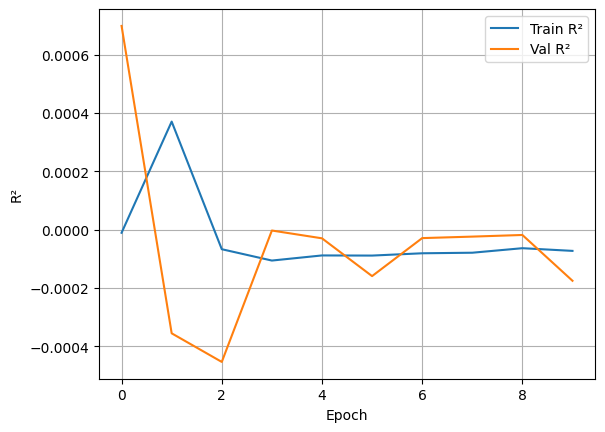

In [24]:
n_features = X_train.shape[1]
lr = 1e-3
criterion = nn.MSELoss()
n_epochs = 10
batch_size = 128
device = "cuda"
seq_len = 1024
d_model=64
num_heads=4
num_layers=3
d_ff=256

model = transformer.TimeSeriesTransformer(
    n_features=n_features,
    d_model=d_model,
    num_heads=num_heads,
    num_layers=num_layers,
    d_ff=d_ff
)

optimizer = optim.Adam(model.parameters(), lr=lr)

r2_train_hist, r2_val_hist = train_model(
    model, optimizer, criterion, 
    X_train, y_train, X_val, y_val,
    epochs=n_epochs, batch_size=batch_size, device=device
)